## Capstone 2 Project: Prediction of WAR in MLB players

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sklearn


# disable warnings
import warnings
warnings.filterwarnings('ignore') 


csvfile = 'capstone_2_df.csv'

mlb_df = pd.read_csv(csvfile)
mlb_df.drop(['SampleID.1', 'POS.1', 'Def_WP', 'Def_ZR'], axis=1, inplace=True)

pd.set_option('display.max_columns', 100)


In [2]:
# normalizing specific numeric features
from sklearn import preprocessing

# pulling out features that will be normalized
feats_to_normalize = ['AGE', 'G', 'GS', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'TB', 'BB', 'IBB', 'SO', 'SF', 'SH', 'RBI', 'DP', 'SB', 'CS', 'DRC+', 'DRC+ SD', 'BRR', 'InnOuts', 'Def_PO', 'Def_A', 'Def_E', 'Def_DP', 'Def_PB', 'Def_SB', 'Def_CS', 'Def_DRAA', 'Def_FRAA']
mlb_df_norm_feats = pd.DataFrame(mlb_df, columns = feats_to_normalize)
mlb_df_no_norm_feats = mlb_df.drop(columns = feats_to_normalize)

# normalizing features
min_max_scaler = preprocessing.MinMaxScaler()
normalized_feats = min_max_scaler.fit_transform(mlb_df_norm_feats)
normalized_feats = pd.DataFrame(normalized_feats, columns = feats_to_normalize, index = mlb_df_no_norm_feats.index)

# creating new dataframe by combining back normalized and non-normalized features
mlb_df_normalized = pd.concat([mlb_df_no_norm_feats, normalized_feats], axis = 1)

# creating dummy variables for categorical data
categ_feats = ['POS', 'teamID', 'League']
mlb_df_normalized = pd.get_dummies(mlb_df_normalized, columns = categ_feats) 

# dropping NaN rows
mlb_df_normalized.drop(pd.isnull(mlb_df_normalized).any(1).nonzero()[0], axis=0, inplace=True)

# train test split
#X = mlb_df_normalized.drop(['BWARP', 'SampleID', 'NAME', 'playerID', 'lahmanID'], axis=1)
X = mlb_df_normalized.drop(['BWARP', 'SampleID', 'NAME', 'playerID', 'lahmanID', 'R', 'H', 'RBI', 'HR', 'AVG', 'OBP', 'SLG', 'OPS', 'TB', 'BB', 'IBB'], axis=1)
y = mlb_df_normalized.loc[:,'BWARP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# features list
features_list = list(X.columns)


In [3]:
# function for Mean Absolute Percentage Error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    #y_true_median = np.median(y_true[y_true > 0])   # to address when y_true values are equal to 0
    y_true_median = np.median(y_true)
    y_true[y_true == 0] = .1

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
# function to print out scores

def scoring(y_train_true, y_train_predict, y_test_true, y_test_predict, classifier):
    print(classifier, 'model scores:\n')
    
    # Root Mean Square Error
    print('RMSE for train data:', mean_squared_error(y_train_true, y_train_predict).round(4))
    print('RMSE for test data:', mean_squared_error(y_test_true, y_test_predict).round(4), '\n')
    
    # Variance Score
    print('R2 Variance Score for train data: ', r2_score(y_train_true, y_train_predict).round(4))
    print('R2 Variance Score for test data: ', r2_score(y_test_true, y_test_predict).round(4), '\n')
    
    # Mean Absolute Error
    print('MAE for train data: ', mean_absolute_error(y_train_true, y_train_predict).round(4))
    print('MAE for test data: ', mean_absolute_error(y_test_true, y_test_predict).round(4), '\n')
    
    # Mean Absolute Percentage Error
    print('MAPE for train data: ', mean_absolute_percentage_error(y_train_true, y_train_predict).round(4), '%')
    print('MAPE for test data: ', mean_absolute_percentage_error(y_test_true, y_test_predict).round(4), '%', '\n')

Linear Regression model scores:

RMSE for train data: 0.047
RMSE for test data: 0.0454 

R2 Variance Score for train data:  0.9831
R2 Variance Score for test data:  0.9838 

MAE for train data:  0.155
MAE for test data:  0.1534 

MAPE for train data:  39.3903 %
MAPE for test data:  38.177 % 



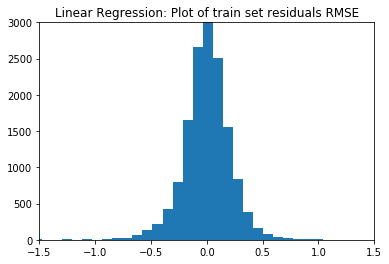

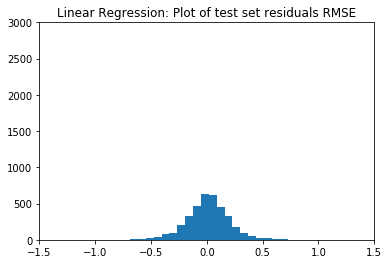

CPU times: user 1.14 s, sys: 121 ms, total: 1.27 s
Wall time: 758 ms


In [5]:
%%time
# baseline linear regression

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(fit_intercept=False)   
lin_reg.fit(X_train, y_train)

lin_reg_train_predict = lin_reg.predict(X_train)
lin_reg_test_predict = lin_reg.predict(X_test)

scoring(y_train, lin_reg_train_predict, y_test, lin_reg_test_predict, 'Linear Regression')

# plotting RMSE for training set
plt.hist(lin_reg_train_predict - y_train, bins=50)
plt.title('Linear Regression: Plot of train set residuals RMSE')
plt.xlim(-1.5, 1.5)
plt.ylim(0, 3000)
plt.show()

# plotting RMSE for testing set
plt.hist(lin_reg_test_predict - y_test, bins=50)
plt.title('Linear Regression: Plot of test set residuals RMSE')
plt.xlim(-1.5, 1.5)
plt.ylim(0, 3000)
plt.show()


In [6]:
%%time
# random forest regression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
    
param_grid_rf = {'n_estimators': np.arange(100, 150, 25),
                 'max_features': ['sqrt'],
                 'criterion': ['mae']} 

rf = RandomForestRegressor()
rf_random_grid = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, cv=3)
rf_random_grid.fit(X_train, y_train)

rf_train_predict = rf_random_grid.predict(X_train)
rf_test_predict = rf_random_grid.predict(X_test)

scoring(y_train, rf_train_predict, y_test, rf_test_predict, 'Random Forest')

Random Forest model scores:

RMSE for train data: 0.0348
RMSE for test data: 0.2276 

R2 Variance Score for train data:  0.9875
R2 Variance Score for test data:  0.9189 

MAE for train data:  0.1198
MAE for test data:  0.3137 

MAPE for train data:  23.3052 %
MAPE for test data:  54.7324 % 

CPU times: user 18min 41s, sys: 8.97 s, total: 18min 50s
Wall time: 19min 37s


In [7]:
print('Random Forest Best Parameters:', rf_random_grid.best_params_)

Random Forest Best Parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'criterion': 'mae'}


In [8]:
%%time
# XGBoost

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

param_grid_xgb = {'n_estimators': np.arange(100, 150, 25),
                 'max_depth': np.arange(5, 8, 1),
                 'min_child': np.arange(1, 5, 1),
                 'learning_rate': np.arange(.1, .3, .1),
                 'min_child_weight': np.arange(1, 3, 1)} 

xgb_reg = XGBRegressor(objective='reg:linear')
xgb_reg_grid = RandomizedSearchCV(xgb_reg, param_distributions=param_grid_xgb, cv=5)
xgb_reg_grid.fit(X_train, y_train)

xgb_train_predict = xgb_reg_grid.predict(X_train)
xgb_test_predict = xgb_reg_grid.predict(X_test)

scoring(y_train, xgb_train_predict, y_test, xgb_test_predict, 'XGBoost')

XGBoost model scores:

RMSE for train data: 0.0155
RMSE for test data: 0.0364 

R2 Variance Score for train data:  0.9944
R2 Variance Score for test data:  0.987 

MAE for train data:  0.0928
MAE for test data:  0.1341 

MAPE for train data:  24.1544 %
MAPE for test data:  28.6853 % 

CPU times: user 3min 34s, sys: 2.03 s, total: 3min 36s
Wall time: 3min 42s


In [9]:
print('XGBoost Best Parameters:', xgb_reg_grid.best_params_)

XGBoost Best Parameters: {'n_estimators': 125, 'min_child_weight': 1, 'min_child': 3, 'max_depth': 5, 'learning_rate': 0.2}


In [10]:
%%time
# feature importance using Random Forest

sel_rf = SelectFromModel(RandomForestRegressor(n_estimators = 100))
sel_rf.fit(X_train, y_train)

# what features are important
sel_rf.get_support()

# make a list and count of selected features
selected_feat_rf = X_train.columns[(sel_rf.get_support())]
len(selected_feat_rf)

# print names of selected features
print('Random Forest most important features:', selected_feat_rf)

Random Forest most important features: Index(['DRC+', 'BRR', 'InnOuts', 'Def_DRAA', 'Def_FRAA'], dtype='object')
CPU times: user 23.5 s, sys: 239 ms, total: 23.7 s
Wall time: 24.4 s


In [11]:
%%time
# feature importance using XGBoost

sel_xgb = SelectFromModel(XGBRegressor(n_estimators = 100))
sel_xgb.fit(X_train, y_train)

# what features are important
sel_xgb.get_support()

# make a list and count of selected features
selected_feat_xgb = X_train.columns[(sel_xgb.get_support())]
len(selected_feat_xgb)

# print names of selected features
print('XGBoost most important features:', selected_feat_xgb)

XGBoost most important features: Index(['PA', 'DRC+', 'BRR', 'InnOuts', 'Def_A', 'Def_SB', 'Def_CS', 'Def_DRAA',
       'Def_FRAA', 'POS_1B'],
      dtype='object')
CPU times: user 2.23 s, sys: 27.4 ms, total: 2.26 s
Wall time: 2.34 s


In [12]:
%%time
# feature importance using Linear Regression

sel_lr = SelectFromModel(LinearRegression())
sel_lr.fit(X_train, y_train)

# what features are important
sel_lr.get_support()

# make a list and count of selected features
selected_feat_lr = X_train.columns[(sel_lr.get_support())]
len(selected_feat_lr)

# print names of selected features
print('Linear Regression most important features:', selected_feat_lr)

Linear Regression most important features: Index(['PA', 'DRC+', 'BRR', 'Def_A', 'Def_DP', 'Def_SB', 'Def_CS', 'Def_DRAA',
       'Def_FRAA'],
      dtype='object')
CPU times: user 131 ms, sys: 51.6 ms, total: 183 ms
Wall time: 160 ms
